In [19]:
from time import time

import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

In [20]:
def make_gender_mtl_data(X, y):
    y_male = y.copy()
    y_male[X['sex'] == 1] = np.nan
    y_female = y.copy()
    y_female[X['sex'] == 0] = np.nan
    return pd.concat([y_female, y_male], axis=1)

def onehot_pos_embedding(x):
    onehot = np.zeros((6, 6))
    for i in range(6):
        onehot[i, i] = 1
    onehot = np.repeat(onehot[np.newaxis, :, :], x.shape[0], axis=0)
    return np.concatenate((x[:, :, np.newaxis], onehot), axis=2)


In [21]:
pre_train_path = None

random_state = 2016
dataset = pd.read_csv('nam/data/recid.data', delimiter=' ', header=None)
dataset.columns = ["age", "race", "sex", "priors_count", "length_of_stay", "c_charge_degree", "two_year_recid"]
binary = ['sex', 'c_charge_degree']
other = ['age', 'race', 'priors_count', 'length_of_stay']
# scaler = MinMaxScaler((-1, 1))
# dataset[other] = scaler.fit_transform(dataset[other])
dataset[binary] = dataset[binary] - 1

X_data = dataset.drop(columns=['two_year_recid']).to_numpy()
y_data = dataset['two_year_recid'].to_numpy().reshape(-1, 1)
X_data = onehot_pos_embedding(X_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, test_size=0.2, random_state=random_state)

#Single Task NAMs Classification
s_time = time()
model = NAMClassifier(
    num_epochs=1000,
    num_learners=20,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    device='cuda:0'
)
    

In [22]:
model.fit(X_train, y_train)

Format converting and model initializing are done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
pred, feature, feature_after_att = model.predict_proba(X_test)

In [53]:
print(sk_metrics.roc_auc_score(y_test, pred))

0.7507056607599261


In [24]:

feature_after_att = feature_after_att.detach().numpy()
pred = np.squeeze(pred).tolist()

In [25]:
X_test=X_test[:, :, 0]

In [26]:
X_test

array([[28.,  3.,  1.,  0.,  1.,  0.],
       [40.,  1.,  1., 15., 55.,  0.],
       [31.,  1.,  1.,  0.,  0.,  0.],
       ...,
       [45.,  3.,  1.,  1.,  1.,  1.],
       [25.,  3.,  1.,  3., 19.,  0.],
       [34.,  3.,  1.,  1.,  3.,  0.]])

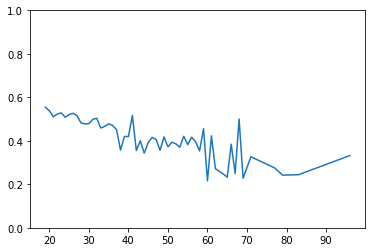

In [44]:
j = 0
curr_data_list = []
for i in range(len(X_test)):
    curr_data_list.append(X_test[i][j])
X = curr_data_list
Y = pred
df = pd.DataFrame(list(zip(X, Y)),
               columns =['age', 'pred'])
df
averaged = df.groupby('age').mean()

averaged['age'] = averaged.index
X = averaged["age"].tolist()
Y = averaged["pred"].tolist()
plt.ylim([0, 1])
plt.plot(X, Y)


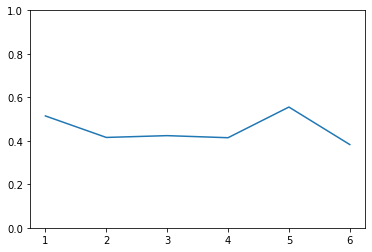

In [45]:
j = 1
curr_data_list = []
for i in range(len(X_test)):
    curr_data_list.append(X_test[i][j])
X = curr_data_list
Y = pred
df = pd.DataFrame(list(zip(X, Y)),
               columns =['race', 'pred'])
df
averaged = df.groupby('race').mean()

averaged['race'] = averaged.index
X = averaged["race"].tolist()
Y = averaged["pred"].tolist()
plt.ylim([0, 1])
plt.plot(X, Y)


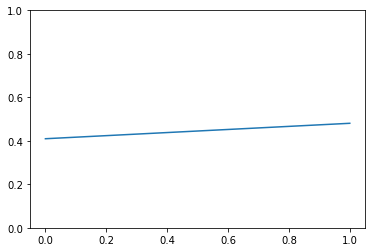

In [46]:
j = 2
curr_data_list = []
for i in range(len(X_test)):
    curr_data_list.append(X_test[i][j])
X = curr_data_list
Y = pred
df = pd.DataFrame(list(zip(X, Y)),
               columns =['sex', 'pred'])
df
averaged = df.groupby('sex').mean()

averaged['sex'] = averaged.index
X = averaged["sex"].tolist()
Y = averaged["pred"].tolist()
plt.ylim([0, 1])
plt.plot(X, Y)


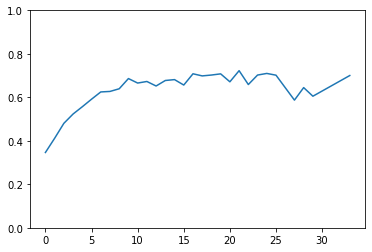

In [48]:
j = 3
curr_data_list = []
for i in range(len(X_test)):
    curr_data_list.append(X_test[i][j])
X = curr_data_list
Y = pred
df = pd.DataFrame(list(zip(X, Y)),
               columns =['priors_count', 'pred'])
df
averaged = df.groupby('priors_count').mean()

averaged['priors_count'] = averaged.index
X = averaged["priors_count"].tolist()
Y = averaged["pred"].tolist()
plt.ylim([0, 1])
plt.plot(X, Y)


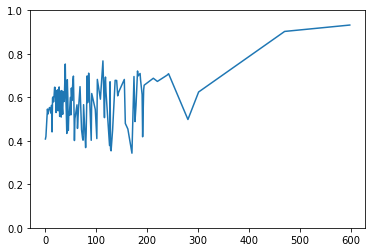

In [49]:
j = 4
curr_data_list = []
for i in range(len(X_test)):
    curr_data_list.append(X_test[i][j])
X = curr_data_list
Y = pred
df = pd.DataFrame(list(zip(X, Y)),
               columns =['length_of_stay', 'pred'])
df
averaged = df.groupby('length_of_stay').mean()

averaged['length_of_stay'] = averaged.index
X = averaged["length_of_stay"].tolist()
Y = averaged["pred"].tolist()
plt.ylim([0, 1])
plt.plot(X, Y)


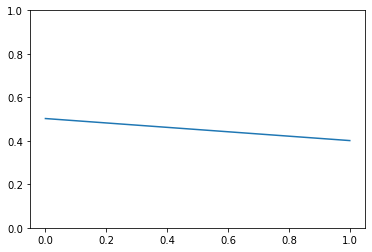

In [51]:
j = 5
curr_data_list = []
for i in range(len(X_test)):
    curr_data_list.append(X_test[i][j])
X = curr_data_list
Y = pred
df = pd.DataFrame(list(zip(X, Y)),
               columns =['c_charge_degree', 'pred'])
df
averaged = df.groupby('c_charge_degree').mean()

averaged['c_charge_degree'] = averaged.index
X = averaged["c_charge_degree"].tolist()
Y = averaged["pred"].tolist()
plt.ylim([0, 1])
plt.plot(X, Y)
